In [1]:
from iads.nlp import preprocessing

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from translate import Translator
from langdetect import detect 
import re

2023-02-22 15:29:25.854627: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-22 15:29:26.134125: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-22 15:29:26.188476: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/gurobi801/linux64/lib
2023-02-22 15:29:26.188507: I tensorflow/compiler/xla/s

# I. Chargement des données :

In [40]:
df_jeux_up = pd.read_csv("../data/details_categ.csv")

# II. Prédire les catégories à partir de la description :

## 1. Les déscriptions manquantes : 

Les courtes descriptions dans la base de données

In [3]:
df_jeux_up[df_jeux_up["description"].map(str.strip).map(len) < 20]['description'].unique()[:10]

array(['\n                      Aucune description\n                  ',
       '\n                      Le trio magique\n                  ',
       '\n                      Essen 2012\n                  ',
       '\n                      Jeux sur les trains\n\n                  ',
       '\n                      Essen 2012\n\n                  ',
       '\n                      La version voyage\n\n                  ',
       "\n                      L'ancêtre du Mölkky\n                  ",
       '\n                      Duel de dés.\n\n                  ',
       '\n                      Goodies\n                  ',
       '\n                      Tuiles bonus\n                  '],
      dtype=object)

On remarque qu'il y'a des descriptions sous la forme `Aucune description` qu'on supprimera 

In [4]:
print("Le nombre de jeux avec la description 'Aucune description' :")
aucune_desc = df_jeux_up["description"].map(lambda d : "Aucune description" in d)
aucune_desc.astype(int).sum()

Le nombre de jeux avec la description 'Aucune description' :


1857

In [41]:
df_jeux_up["description"] = df_jeux_up["description"].map(str.strip).replace("Aucune description", np.NaN)

In [6]:
print("Apres la suppression de 'Aucune description', nombre de jeux avec cette description :")
aucune_desc = df_jeux_up["description"].map(lambda d : "Aucune description" in d if type(d) == str else False)
aucune_desc.astype(int).sum()

Apres la suppression de 'Aucune description', nombre de jeux avec cette description :


0

## 2. Catégories et Déscriptions :

In [7]:
cat_isna  = df_jeux_up["categories"].isna()
desc_isna = df_jeux_up["description"].isna()

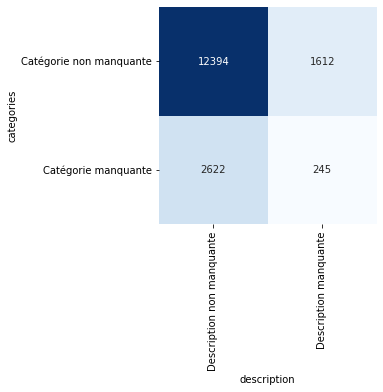

In [8]:
table = pd.crosstab(index=cat_isna, columns=desc_isna, margins=False)
table = table.rename(columns={False: 'Description non manquante', True: 'Description manquante'})
table = table.rename(index={False: 'Catégorie non manquante', True: 'Catégorie manquante'})
sns.heatmap(table, annot=True, cmap='Blues', fmt='g', cbar=False, square=True)
plt.show()

- On remarque qu'il y a 12394 jeux avec dès une description et une catégorie soit 73% de la base de données, qu'on utilisera pour le train de nos classifers.

- Et il y a aussi 1857 jeux sans description, donc des lignes à "supprimer" pour nos classifiers.

- On voit aussi 2622 avec des descriptions mais sans catégorie, cela on s'en servira pour leur génerer une catégorie avec nos prédicteurs

In [9]:
descriptions = df_jeux_up["description"][~desc_isna]

## 3. Des descriptions dans d'autres langues :

In [10]:
from tqdm import tqdm
tqdm.pandas()

In [11]:
desc_lang = descriptions.progress_apply(detect)
val, count = np.unique(desc_lang, return_counts=True)

index = count.argsort()[::-1]
count = count[index]
val   = val[index]

100%|████████████████████████████████████| 15016/15016 [01:03<00:00, 235.44it/s]


In [12]:
fr = np.where(val == 'fr')[0][0]

count_autre = np.delete(count, fr)

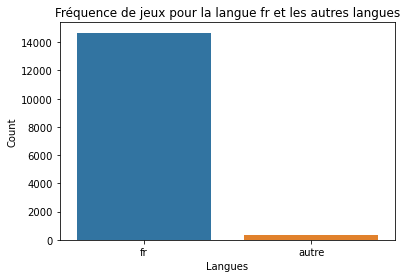

In [13]:
sns.barplot(x = ['fr','autre'], y = [count[fr], count_autre.sum()])
plt.xlabel("Langues")
plt.ylabel("Count")
plt.title("Fréquence de jeux pour la langue fr et les autres langues")
plt.show()

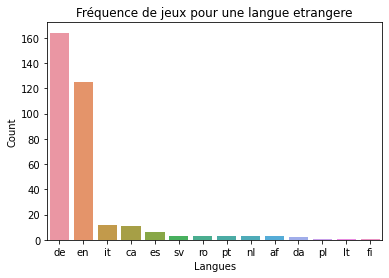

In [14]:
val_autre   = np.delete(val, fr)
count_autre = np.delete(count, fr)
sns.barplot(val_autre, count_autre)
plt.xlabel("Langues")
plt.ylabel("Count")
plt.title("Fréquence de jeux pour une langue etrangere")
plt.show()

**Traduire les descriptions :**

In [ ]:
translator = Translator(to_lang='fr')

def traduire_phrase(phrase):

    try:
        phrase_lang = detect(phrase)

        if phrase_lang != 'fr' :
            return translator.translate(phrase)

        return phrase
    
    except Exception:
        return phrase

# Diviser chaque ligne de la colonne "description" en phrases
phrases = df_jeux_up["description"].progress_apply(lambda x: re.split("[\.\!\?\,\;\:\n]", x) if type(x) == str else np.NaN)

# Traduire chaque phrase individuellement
traductions = phrases.progress_apply(lambda x: list(map(traduire_phrase, x)) if type(x) == list else np.NaN)

# Concaténer les traductions en un seul texte traduit
texte_traduit = traductions.progress_apply(lambda x: " ".join(x) if type(x) == list else np.NaN)

In [ ]:
# Mettre à jour les descriptions
df_jeux_up["description"] = texte_traduit

In [ ]:
df_jeux_up.to_csv('../data/details_desc_trad.csv', index=False)

## 4. Nettoyer les descriptions :

In [17]:
# descriptions = descriptions.map(preprocessing.clean_text)

In [18]:
# descriptions = descriptions.map(preprocessing.tokenize_text)

In [19]:
# c = b.map(lambda tokens : preprocessing.remove_stopwords(tokens, preprocessing.DESC_STOP_WORDS))

In [20]:
# d = c.map(preprocessing.lemmatize_tokens)